In [1]:
import getpass, math, matplotlib, os, pymysql, time
import networkx as nx, numpy as np, pandas as pd, sqlalchemy as sql

In [2]:
password=getpass.getpass()

connection = pymysql.connect(host='qcontact.c6byqjxwxxbt.us-east-1.rds.amazonaws.com',
                             port=3306,
                             user='admin',
                             password=password,
                             db='',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

········


In [3]:
cursor = connection.cursor()
cursor.execute('USE anon_btlog')
dates=pd.read_sql("SELECT Date, COUNT(*) FROM anon_logdata GROUP BY Date", connection)
dates

,Date,COUNT(*)
0,2005-10-31,335
1,2005-11-01,834
2,2005-11-02,508


In [5]:
firstLast1031=pd.read_sql("SELECT Address, MIN(Time), MAX(Time) FROM anon_logdata "\
                      "WHERE Date='2005-10-31' GROUP BY Address", connection)
firstLast1101=pd.read_sql("SELECT Address, MIN(Time), MAX(Time) FROM anon_logdata "\
                      "WHERE Date='2005-11-01' GROUP BY Address", connection)
firstLast1102=pd.read_sql("SELECT Address, MIN(Time), MAX(Time) FROM anon_logdata "\
                      "WHERE Date='2005-11-02' GROUP BY Address", connection)

In [6]:
def load_cont_graph(firstLast):
    G = nx.Graph()
    for row1 in range(firstLast.shape[0]-1):
        if len(set(list(firstLast.iloc[row1,0])))>1: #check the address in row1 isn't a dummy
            for row2 in range(row1+1, firstLast.shape[0]):
                if len(set(list(firstLast.iloc[row2,0])))>1: #check the address in row2 isn't a dummy
                    #check if they overlapped
                    if max(firstLast.iloc[row1,1], firstLast.iloc[row2,1])<min(firstLast.iloc[row1,2],
                                                                        firstLast.iloc[row2,2]):
                        t_start=max(firstLast.iloc[row1,1], firstLast.iloc[row2,1])
                        t_tog=min(firstLast.iloc[row1,2], firstLast.iloc[row2,2])-t_start
                        G.add_edge(firstLast.iloc[row1,0],firstLast.iloc[row2,0], 
                                   t_start=t_start.total_seconds(), t_tog=t_tog.total_seconds())
    nx.set_node_attributes(G, 0, 'tested')
    nx.set_node_attributes(G, 0, 'infected')
    nx.set_node_attributes(G, -1, 'source')
    nx.set_node_attributes(G, -1, 'inf_time')
    return G

In [7]:
cont_graph1031=load_cont_graph(firstLast1031)
cont_graph1101=load_cont_graph(firstLast1101)
cont_graph1102=load_cont_graph(firstLast1102)

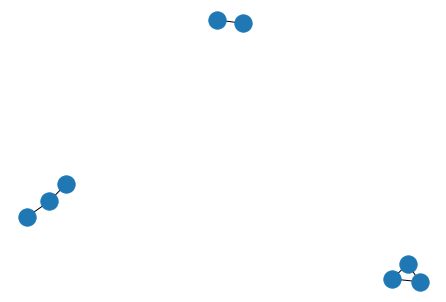

In [8]:
%matplotlib inline
nx.draw(cont_graph1031)
#Not many interactions on Oct 31

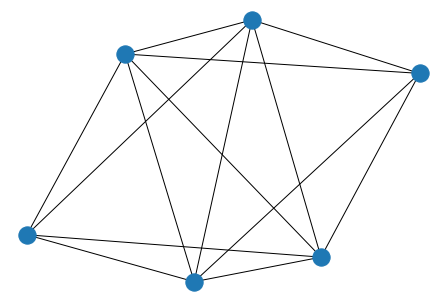

In [9]:
#Now, only draw the connected portion for Nov 1
nx.draw(cont_graph1101.subgraph(max(nx.connected_components(cont_graph1101), key=len)))

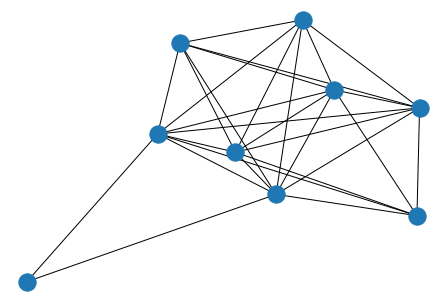

In [10]:
#And for 2005-11-02
nx.draw(cont_graph1102.subgraph(max(nx.connected_components(cont_graph1102), key=len)))

In [11]:
[(e, cont_graph1102.edges[e]['t_start'], cont_graph1102.edges[e]['t_tog']) \
 for e in cont_graph1102.edges(max(nx.connected_components(cont_graph1102), key=len))]

[(('01f052ae6021e25f2f00d61e88287ae3', '4a3dacbfc570d4931d99ae862a73791d'),
  50060.0,
  121.0),
 (('01f052ae6021e25f2f00d61e88287ae3', '68ece46dd8262e0b422773460844ce73'),
  50060.0,
  121.0),
 (('01f052ae6021e25f2f00d61e88287ae3', '735c38802d17fd219577cea31faa082f'),
  50060.0,
  121.0),
 (('01f052ae6021e25f2f00d61e88287ae3', '776d3625e915cd55b1a3b249b958cebe'),
  50060.0,
  121.0),
 (('01f052ae6021e25f2f00d61e88287ae3', '96dbec31c17d68e38ec48406ffa99a8d'),
  50060.0,
  121.0),
 (('01f052ae6021e25f2f00d61e88287ae3', 'a75565a0203fd6081889f42b1d246161'),
  50089.0,
  92.0),
 (('a75565a0203fd6081889f42b1d246161', '4a3dacbfc570d4931d99ae862a73791d'),
  50089.0,
  513.0),
 (('a75565a0203fd6081889f42b1d246161', '68ece46dd8262e0b422773460844ce73'),
  50089.0,
  272.0),
 (('a75565a0203fd6081889f42b1d246161', '735c38802d17fd219577cea31faa082f'),
  50089.0,
  92.0),
 (('a75565a0203fd6081889f42b1d246161', '776d3625e915cd55b1a3b249b958cebe'),
  50089.0,
  633.0),
 (('a75565a0203fd6081889f42b1d24

In [12]:
nx.to_dict_of_dicts(cont_graph1102.subgraph(max(nx.connected_components(cont_graph1102), key=len)))

{'01f052ae6021e25f2f00d61e88287ae3': {'4a3dacbfc570d4931d99ae862a73791d': {'t_start': 50060.0,
   't_tog': 121.0},
  '68ece46dd8262e0b422773460844ce73': {'t_start': 50060.0, 't_tog': 121.0},
  '735c38802d17fd219577cea31faa082f': {'t_start': 50060.0, 't_tog': 121.0},
  '776d3625e915cd55b1a3b249b958cebe': {'t_start': 50060.0, 't_tog': 121.0},
  '96dbec31c17d68e38ec48406ffa99a8d': {'t_start': 50060.0, 't_tog': 121.0},
  'a75565a0203fd6081889f42b1d246161': {'t_start': 50089.0, 't_tog': 92.0}},
 '4a3dacbfc570d4931d99ae862a73791d': {'01f052ae6021e25f2f00d61e88287ae3': {'t_start': 50060.0,
   't_tog': 121.0},
  '68ece46dd8262e0b422773460844ce73': {'t_start': 50048.0, 't_tog': 313.0},
  '735c38802d17fd219577cea31faa082f': {'t_start': 50048.0, 't_tog': 133.0},
  '776d3625e915cd55b1a3b249b958cebe': {'t_start': 50041.0, 't_tog': 561.0},
  '96dbec31c17d68e38ec48406ffa99a8d': {'t_start': 50041.0, 't_tog': 561.0},
  'a75565a0203fd6081889f42b1d246161': {'t_start': 50089.0, 't_tog': 513.0},
  'c4e5c70

In [13]:
#Simulates one node being infected where infection rate is inf_rate (if they spent time 1 together)
#Inputs a graph where that node was just infected by source (node) at inf_time
#Outputs a graph that simulates that node's infection other nodes
def sim_node_inf(graph, node, source, inf_time, inf_rate):
    new_graph=graph
    #Node received infection from source at inf_time
    new_graph.nodes[node]['infected']=1 
    new_graph.nodes[node]['source']=source
    new_graph.nodes[node]['inf_time']=inf_time 
    
    #The infection can spread to other nodes it interacted with after the infection time
    poss_spread=[n for n in new_graph.neighbors(node) if new_graph.edges[(node,n)]['t_start']>inf_time]
    print('Node {} infected by {} at time {}. Possible new infections:'.format(node, source, inf_time),
          ', '.join([str(n) for n in poss_spread]))
    
    for spread_node in poss_spread: #For each of these nodes
        inf_chance=1-math.exp(-new_graph.edges[(node,spread_node)]['t_tog']/inf_rate) #Calculate the infection chance
        #The new infection is assumed to be the end of the source and infected nodes' time together
        new_inf_time=new_graph.edges[(node,spread_node)]['t_start']+new_graph.edges[(node,spread_node)]['t_tog']
        
        #If there is an infection (and the spread node isn't already infected
        if np.random.rand()<inf_chance and not new_graph.nodes[spread_node]['infected']:
            #Generate a new graph with that node as an infection source
            new_graph=sim_node_inf(new_graph, spread_node, node, new_inf_time, inf_rate)
            
    return new_graph

#Simulates infection of every node in a graph
#Inputs are a contact graph (such as from make_cont_ba), num_seed and num_tested as number
# of nodes seeded and tested, and inf_rate (infection rate if they spent time 1 together)
#Outputs is a graph with simulation for infections and tests
def sim_graph_inf(graph, num_seed, num_tested, inf_rate):
    new_graph=graph
    
    #Choose num_seed nodes to be the sources of infection
    seeds=np.random.choice(new_graph.nodes,num_seed, replace=False)
    for seed_node in seeds:
        new_graph.nodes[seed_node]['infected']=1
    
    #then simulate the resulting infections
    for source_node in seeds:
        new_graph=sim_node_inf(new_graph, source_node, -1, 0, inf_rate)
        
    #then choose num_tested to be tested
    for t_node in np.random.choice(graph.nodes,num_tested, replace=False):
        new_graph.nodes[t_node]['tested']=1
    return new_graph

In [14]:
cont_graph1102=load_cont_graph(firstLast1102)
cont_graph1102conn=cont_graph1102.subgraph(max(nx.connected_components(cont_graph1102), key=len))
inf_graph1102=sim_graph_inf(cont_graph1102conn, 2, 2, 3000)
print('Infected:', [inf_graph1102.nodes[node]['infected'] for node in inf_graph1102.nodes])
print('Tested:  ', [inf_graph1102.nodes[node]['tested'] for node in inf_graph1102.nodes])

Node 01f052ae6021e25f2f00d61e88287ae3 infected by -1 at time 0. Possible new infections: 4a3dacbfc570d4931d99ae862a73791d, 68ece46dd8262e0b422773460844ce73, 735c38802d17fd219577cea31faa082f, 776d3625e915cd55b1a3b249b958cebe, 96dbec31c17d68e38ec48406ffa99a8d, a75565a0203fd6081889f42b1d246161
Node 2d1f2bd68c3d4a16a972198da151bd9a infected by -1 at time 0. Possible new infections: 776d3625e915cd55b1a3b249b958cebe, 96dbec31c17d68e38ec48406ffa99a8d
Node 776d3625e915cd55b1a3b249b958cebe infected by 2d1f2bd68c3d4a16a972198da151bd9a at time 46886.0. Possible new infections: 01f052ae6021e25f2f00d61e88287ae3, 4a3dacbfc570d4931d99ae862a73791d, 68ece46dd8262e0b422773460844ce73, 735c38802d17fd219577cea31faa082f, a75565a0203fd6081889f42b1d246161, c4e5c70925aac090bb913ba983ef168e
Node a75565a0203fd6081889f42b1d246161 infected by 776d3625e915cd55b1a3b249b958cebe at time 50722.0. Possible new infections: 
Node 96dbec31c17d68e38ec48406ffa99a8d infected by 2d1f2bd68c3d4a16a972198da151bd9a at time 46886.0

In [ ]:
##This is the code for populating the database

sql_file = open('Anonymized_BT_Logs_20070903_1833.sql','r')

# Create an empty command string
sql_command = ''

count_char=0 #Count the number of characters processed
count_char_mil=0 #Count the millions, so the computer knows when to print progress

print('Starting', time.ctime())
# Iterate over all lines in the sql file
for line in sql_file:
    count_char+=len(line)
    if count_char>(count_char_mil+1)*1000000: #If you've hit another million
        print(count_char, 'characters', time.ctime()) #Print the characters processed and time
        count_char_mil+=1
    # Ignore commented lines
    if not line.startswith('--') and line.strip('\n'):
        # Append line to the command string
        sql_command += line.strip('\n')

        # If the command string ends with ';', it is a full statement
        if sql_command.endswith(';'):
            # Try to execute statement and commit it
            for sql_split in sql_command.split(';'):
                if len(sql_split):
                    cursor=connection.cursor()
                    cursor.execute(sql_split+';')
            connection.commit()

connection.close()